In [1]:
import numpy as np

import sympy as sym

import itertools

In [2]:
from importlib.machinery import SourceFileLoader

main = SourceFileLoader("main", "main.py").load_module()

from main import *

In [3]:
import matplotlib.pyplot as plt

import matplotlib

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
import matplotlib.colors as colors

In [5]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

## The case of two bits strategies

To test the formulation we compare the following payoffs.

In [6]:
c = np.random.randint(0, 1)
b = np.random.randint(1, 3)

for _ in range(1000):

    p1, p2, q1, q2 = np.random.random(4)

    one_bit_M = transition_matrix_one_bit(p=[p1, p2], q=[q1, q2])

    two_bit_M = transition_matrix(p=[p1, p2, p1, p2], q=[q1, q2, q1, q2], bits=4)

    ss_one_bit = invariant_distribution(one_bit_M)
    ss_two_bit = invariant_distribution(two_bit_M)

    assert np.isclose(
        ss_one_bit @ np.array([b - c, -c, b, 0]), ss_two_bit @ payoffs_vector(c, b)
    )

**Cooperation**

In [7]:
c = np.random.randint(0, 1)
b = np.random.randint(1, 3)

for _ in range(1000):

    p1, p2, q1, q2 = np.random.random(4)

    one_bit_M = transition_matrix_one_bit(p=[p1, p2], q=[q1, q2])

    two_bit_M = transition_matrix(p=[p1, p2, p1, p2], q=[q1, q2, q1, q2], bits=4)

    ss_one_bit = invariant_distribution(one_bit_M)
    ss_two_bit = invariant_distribution(two_bit_M)

    assert np.isclose(
        cooperation_rate(ss_one_bit, size=4), cooperation_rate(ss_two_bit, size=16)
    )

## The case of two bits strategies

In [8]:
c = np.random.randint(0, 1)
b = np.random.randint(1, 3)

for _ in range(1000):

    p1, p2, p3, p4, q1, q2, q3, q4 = np.random.random(8)

    two_bit_M = transition_matrix(p=[p1, p2, p3, p4], q=[q1, q2, q3, q4], bits=4)

    three_bit_M = transition_matrix(
        p=[p1, p2, p3, p4, p1, p2, p3, p4], q=[q1, q2, q3, q4, q1, q2, q3, q4], bits=8
    )

    ss_two_bit = invariant_distribution(two_bit_M)
    ss_three_bit = invariant_distribution(three_bit_M)

    assert np.isclose(
        ss_two_bit @ payoffs_vector(c, b), ss_three_bit @ payoffs_vector(c, b, dim=16)
    )

In [9]:
c = np.random.randint(0, 1)
b = np.random.randint(1, 3)

for _ in range(1000):

    p1, p2, q1, q2 = np.random.random(4)

    two_bit_M = transition_matrix(p=[p1, p2, p3, p4], q=[q1, q2, q3, q4], bits=4)

    three_bit_M = transition_matrix(
        p=[p1, p2, p3, p4, p1, p2, p3, p4], q=[q1, q2, q3, q4, q1, q2, q3, q4], bits=8
    )

    ss_two_bit = invariant_distribution(two_bit_M)
    ss_three_bit = invariant_distribution(three_bit_M)

    assert np.isclose(
        cooperation_rate(ss_two_bit, size=16), cooperation_rate(ss_three_bit, size=64)
    )

## The case of four bits strategies

In [10]:
c = np.random.randint(0, 1)
b = np.random.randint(1, 3)

for _ in range(100):
    p1, p2, p3, p4, p5, p6, p7, p8, q1, q2, q3, q4, q5, q6, q7, q8 = np.random.random(
        16
    )

    m_four_bits = transition_matrix(
        (p1, p2, p3, p4, p5, p6, p7, p8, p1, p2, p3, p4, p5, p6, p7, p8),
        (q1, q2, q3, q4, q5, q6, q7, q8, q1, q2, q3, q4, q5, q6, q7, q8),
        bits=16,
    )

    m_three_bits = transition_matrix(
        (p1, p2, p3, p4, p5, p6, p7, p8), (q1, q2, q3, q4, q5, q6, q7, q8), bits=8
    )

    ss_four = invariant_distribution(m_four_bits)
    ss_three = invariant_distribution(m_three_bits)

    assert np.isclose(
        ss_four @ payoffs_vector(c, b, dim=64), ss_three @ payoffs_vector(c, b, dim=16)
    )

In [11]:
c = np.random.randint(0, 1)
b = np.random.randint(1, 3)

for _ in range(100):
    p1, p2, p3, p4, p5, p6, p7, p8, q1, q2, q3, q4, q5, q6, q7, q8 = np.random.random(
        16
    )

    m_four_bits = transition_matrix(
        (p1, p2, p3, p4, p5, p6, p7, p8, p1, p2, p3, p4, p5, p6, p7, p8),
        (q1, q2, q3, q4, q5, q6, q7, q8, q1, q2, q3, q4, q5, q6, q7, q8),
        bits=16,
    )

    m_three_bits = transition_matrix(
        (p1, p2, p3, p4, p5, p6, p7, p8), (q1, q2, q3, q4, q5, q6, q7, q8), bits=8
    )

    ss_four = invariant_distribution(m_four_bits)
    ss_three = invariant_distribution(m_three_bits)

    assert np.isclose(
        cooperation_rate(ss_three, size=64), cooperation_rate(ss_four, size=256)
    )

**Checks for matlab code**

**The two bits case**

In [12]:
np.random.seed(100)
p1, p2 = np.random.random(4), np.random.random(4)

In [13]:
p1, p2

(array([0.54340494, 0.27836939, 0.42451759, 0.84477613]),
 array([0.00471886, 0.12156912, 0.67074908, 0.82585276]))

In [14]:
M = transition_matrix(p1, p2, bits=4)

ss = invariant_distribution(M)

In [15]:
ss

array([0.02770631, 0.0540767 , 0.03207052, 0.06290837, 0.06055705,
       0.27718485, 0.02476668, 0.09362911, 0.02902366, 0.02994831,
       0.03106764, 0.03119363, 0.05947489, 0.09492782, 0.0333284 ,
       0.05813606])

In [16]:
c = 0.1

In [17]:
b = 1

In [18]:
ss @ payoffs_vector(c, b)

0.23470518518107092

In [19]:
cooperation_rate(ss, size=4 ** 2)

0.6328995842008454

**The three bits case**

In [20]:
np.random.seed(200)
sdim = 8

p1, p2 = np.random.random(sdim), np.random.random(sdim)

In [21]:
p1, p2

(array([0.94763226, 0.22654742, 0.59442014, 0.42830868, 0.76414069,
        0.00286059, 0.35742368, 0.90969489]),
 array([0.45608099, 0.98180271, 0.86735699, 0.98602751, 0.92326671,
        0.30369331, 0.84610349, 0.12122197]))

In [22]:
M = transition_matrix(p1, p2, bits=8)

ss = invariant_distribution(M)

In [23]:
c, b = 0.1, 1

In [24]:
ss @ payoffs_vector(c, b, dim=16)

0.6097480267311309

In [25]:
cooperation_rate(ss, sdim ** 2)

0.6081663855976464

**The four bits case**

In [26]:
np.random.seed(300)
bits = 16

p1, p2 = np.random.random(bits), np.random.random(bits)

In [27]:
p1, p2

(array([0.45112257, 0.22102234, 0.36908125, 0.2907757 , 0.24107793,
        0.78204643, 0.81109437, 0.40079054, 0.0259992 , 0.60937305,
        0.6290881 , 0.65192088, 0.8585911 , 0.58680275, 0.70416835,
        0.48590168]),
 array([0.68441634, 0.11236823, 0.1823913 , 0.69704813, 0.36835276,
        0.42729725, 0.39981783, 0.64871212, 0.41334846, 0.16360112,
        0.50836966, 0.51687131, 0.34820519, 0.30225247, 0.22733687,
        0.05458993]))

In [28]:
M = transition_matrix(p1, p2, bits=bits)

ss = invariant_distribution(M)

In [29]:
ss @ payoffs_vector(c, b, dim=64)

0.33135473455700504

In [30]:
cooperation_rate(ss, bits ** 2)

0.5388298223915904

## Evolutionary simulations

In [31]:
import pandas as pd

In [32]:
cs = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

In [33]:
names1 = [f"p_{i}" for i in range(1, 3)] + ["t", "cooperation"]
names2 = [f"p_{i}" for i in range(1, 5)] + ["t", "cooperation"]
names3 = [f"p_{i}" for i in range(1, 9)] + ["t", "cooperation"]
names4 = [f"p_{i}" for i in range(1, 17)] + ["t", "cooperation"]

dfs1 = [
    [pd.read_csv(f"matlab_data/bits_2_beta_0.1_seed_1_c_{c}.csv", names=names1) for c in cs],
    [pd.read_csv(f"matlab_data/bits_4_beta_0.1_seed_1_c_{c}.csv", names=names2) for c in cs],
    [pd.read_csv(f"matlab_data/bits_8_beta_0.1_seed_1_c_{c}.csv", names=names3) for c in cs],
]

dfs2 = [
    [pd.read_csv(f"matlab_data/bits_2_beta_1_seed_1_c_{c}.csv", names=names1) for c in cs],
    [pd.read_csv(f"matlab_data/bits_4_beta_1_seed_1_c_{c}.csv", names=names2) for c in cs],
    [pd.read_csv(f"matlab_data/bits_8_beta_1_seed_1_c_{c}.csv", names=names3) for c in cs],
]

dfs3 = [
    [pd.read_csv(f"matlab_data/bits_2_beta_10_seed_1_c_{c}.csv", names=names1) for c in cs],
    [pd.read_csv(f"matlab_data/bits_4_beta_10_seed_1_c_{c}.csv", names=names2) for c in cs],
    [pd.read_csv(f"matlab_data/bits_8_beta_10_seed_1_c_{c}.csv", names=names3) for c in cs],
]

In [34]:
dfs1 = [[df.drop_duplicates() for df in dfs] for dfs in dfs1]
dfs2 = [[df.drop_duplicates() for df in dfs] for dfs in dfs2]
dfs3 = [[df.drop_duplicates() for df in dfs] for dfs in dfs3]

In [35]:
def frequencies(dfs, max_steps=10 ** 7):

    for df in dfs:
        frequencies = []
        previous = 0
        for value in df["t"][1:]:
            frequencies.append(value - previous)
            previous = value
        frequencies.append(max_steps - previous)

        df["frequencies"] = np.array(frequencies)
        df["frequencies norm"] = np.array(frequencies) / max_steps

    return dfs

In [36]:
df_beta_pnt = [frequencies(dfs) for dfs in dfs1[:-1]] + [frequencies(dfs1[-1], (2 * 10 ** 7))]
df_beta_one = [frequencies(dfs) for dfs in dfs2[:-1]] + [frequencies(dfs2[-1], (2 * 10 ** 7))]
df_beta_ten = [frequencies(dfs) for dfs in dfs3[:-1]] + [frequencies(dfs3[-1], (2 * 10 ** 7))]

In [37]:
labels = [r"$\beta$=0.1", r"$\beta$=1", r"$\beta$=10"]

In [104]:
df5 = [pd.read_csv(f"matlab_data/bits_16_beta_0.1_seed_1_c_{c}.csv", names=names4) for c in cs]
df5 = [df.drop_duplicates() for df in df5]
df5 = frequencies(df5, 10 ** 6)

sxt_bits_points = [sum(df["frequencies norm"] * df["cooperation"]) for df in df5]

In [107]:
df5 = [pd.read_csv(f"matlab_data/bits_16_beta_1_seed_1_c_{c}.csv", names=names4) for c in cs]
df5 = [df.drop_duplicates() for df in df5]
df5 = frequencies(df5, 10 ** 6)

sxt_bits_one_points = [sum(df["frequencies norm"] * df["cooperation"]) for df in df5]

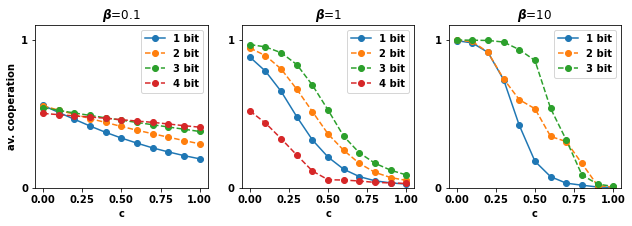

In [113]:
fig, axes = plt.subplots(ncols=3, figsize=(10.5, 3))

for i, gdfs in enumerate([df_beta_pnt, df_beta_one, df_beta_ten]):

    points = [
        [sum(df["frequencies norm"] * df["cooperation"]) for df in dfs] for dfs in gdfs
    ]

    axes[i].plot(np.linspace(0, 1, 11), points[0], "-o", label="1 bit")
    axes[i].plot(np.linspace(0, 1, 11), points[1], "--o", label="2 bit")
    axes[i].plot(np.linspace(0, 1, 11), points[2], "--o", label="3 bit")

    axes[i].set_ylim(0, 1.1)

    axes[i].set_yticks(np.arange(0, 2))

    axes[i].set_xlabel("c")

    axes[i].legend()
    axes[i].set_title(labels[i])

axes[0].set_ylabel("av. cooperation");

axes[0].plot(np.linspace(0, 1, 11), sxt_bits_points, "--o", label="4 bit");
axes[1].plot(np.linspace(0, 1, 11), sxt_bits_one_points, "--o", label="4 bit");

axes[0].legend();
axes[1].legend();

plt.savefig("static/average_cooperation_over_c_with_diff_selection_strength.pdf", bbox_inches='tight')

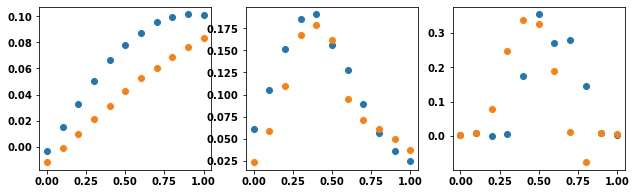

In [143]:
fig, axes = plt.subplots(ncols=3, figsize=(10.5, 3))

for i, gdfs in enumerate([df_beta_pnt, df_beta_one, df_beta_ten]):

    points = [
        [sum(df["frequencies norm"] * df["cooperation"]) for df in dfs] for dfs in gdfs
    ]
    
    ys1 =  np.array(points[1]) - np.array(points[0])
    
    ys2 =  np.array(points[2]) - np.array(points[1])
    
    axes[i].scatter(cs, ys1);
    
    axes[i].scatter(cs, ys2);
    
#     axes[i].legend();
    

In [96]:
dfs = [
    pd.read_csv(f"data/matlab_one_bit_beta_1_seed_{seed}_c_0.3.csv", names=names2)
    for seed in range(1, 11)
]


df2s = [
    pd.read_csv(f"data/matlab_two_bits_beta_1_seed_{seed}_c_0.3.csv", names=names2)
    for seed in range(1, 11)
]

In [97]:
df3s = [
    pd.read_csv(f"data/matlab_three_bits_beta_1_seed_{seed}_c_0.3.csv",
                names=names3)
    for seed in range(1, 11)
]

In [98]:
dfs = [df.drop_duplicates() for df in dfs]

df2s = [df.drop_duplicates() for df in df2s]

df3s = [df.drop_duplicates() for df in df3s]

In [99]:
dfs = frequencies(dfs)

df2s = frequencies(df2s)

df3s = frequencies(df3s)

In [100]:
abundance = [
    (
        df.iloc[df["frequencies"].idxmax()]["p_1"],
        df.iloc[df["frequencies"].idxmax()]["p_2"],
    )
    for df in dfs
]

In [101]:
abundance2 = [
    (
        df.iloc[df["frequencies"].idxmax()]["p_1"],
        df.iloc[df["frequencies"].idxmax()]["p_2"],
        df.iloc[df["frequencies"].idxmax()]["p_3"],
        df.iloc[df["frequencies"].idxmax()]["p_4"],
    )
    for df in df2s
]

In [102]:
abundance3 = [
    (
        df.iloc[df["frequencies"].idxmax()]["p_1"],
        df.iloc[df["frequencies"].idxmax()]["p_2"],
        df.iloc[df["frequencies"].idxmax()]["p_3"],
        df.iloc[df["frequencies"].idxmax()]["p_4"],
        df.iloc[df["frequencies"].idxmax()]["p_5"],
        df.iloc[df["frequencies"].idxmax()]["p_6"],
        df.iloc[df["frequencies"].idxmax()]["p_7"],
        df.iloc[df["frequencies"].idxmax()]["p_8"],
    )
    for df in df3s
]

**Sanity check cooperations**

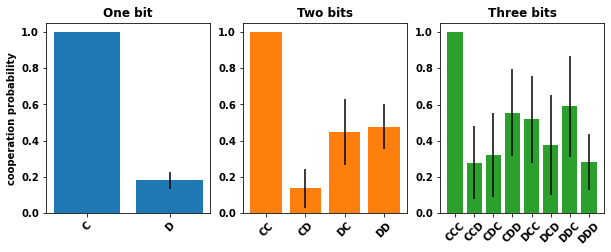

In [103]:
fig, axes = plt.subplots(ncols=3, figsize=(10, 3.5))

heights = [[b[i] for b in abundance] for i in range(2)]

errors = [np.std(h) for h in heights]

for i in range(2):
    axes[0].bar(i + 1, np.mean(heights[i]), yerr=errors[i], color="C0")

axes[0].set_xticks([1, 2])
axes[0].set_xticklabels(["C", "D"], rotation=45)
axes[0].set_title("One bit", fontweight="bold")

axes[0].set_ylabel("cooperation probability")

heights = [[b[i] for b in abundance2] for i in range(4)]
errors = [np.std(h) for h in heights]

for i in range(4):
    axes[1].bar(i + 1, np.mean(heights[i]), yerr=errors[i], color="C1")

axes[1].set_xticks([1, 2, 3, 4])
axes[1].set_xticklabels(["CC", "CD", "DC", "DD"], rotation=45)
axes[1].set_title("Two bits", fontweight="bold")

heights = [[b[i] for b in abundance3] for i in range(8)]
errors = [np.std(h) for h in heights]

for i in range(8):
    axes[2].bar(i + 1, np.mean(heights[i]), yerr=errors[i], color="C2")

axes[2].set_xticks([1, 2, 3, 4, 5, 6, 7, 8])
axes[2].set_xticklabels(["CCC", "CCD", "CDC", "CDD", "DCC", "DCD", "DDC", "DDD"], rotation=45)
axes[2].set_title("Three bits", fontweight="bold");

# axes[1].text(-0.9, -0.2, "$b=1$ & $c=0.3$", fontsize=12)